# [EDA - UCB Measuring Hate Speech](https://huggingface.co/datasets/ucberkeley-dlab/measuring-hate-speech)

## Situation

We have do a basic EDA of a dataset taken from the HuggingFace website. We need to learn as much as possible about the data through this.

I chose this particular dataset because we have raw text in the dataset along with other columns, which opens up a stream of possibilities to do what kind of Analysis we can do on the data. Also, I am kind of interested in digging further into the dataset and see what kinds of models I can build using this data.

#### About the data

The data has several columns, out of which I have focused just on the following, since the rest were race and ethnicity details about annotators and the target, which I would be an overkill for this task (and my system). This table is directly taken from the [original paper](https://arxiv.org/pdf/2009.10277.pdf) and I included it here as I felt this would be a good description about the columns.

| Item name | Prompt | Response options |
| --- | --- | --- |
1 - Sentiment | How would you describe the sentiment of this comment? | Strongly negative, somewhat negative, neutral, somewhat positive, strongly positive |
2 - Respect | Is this comment respectful towards the group(s) you previously identified? | Strongly disrespectful, disrespectful, neutral, respectful, strongly respectful |
3 - Insult | Do you agree or disagree with the following statement: This comment is insulting towards the group(s) you previously identified. | Strongly disagree, disagree, neither disagree nor agree, agree, strongly agree |
4 - Humiliate | Do you agree or disagree with the following statement: This comment is humiliating towards the group(s) you previously identified. | Strongly disagree, disagree, neither disagree nor agree, agree, strongly agree |
5 - Status | This comment states that the group(s) you previously identified is: | Strongly inferior, inferior, neither superior nor inferior, superior, strongly superior |
6 - Dehumanize | Do you agree or disagree with the following statement: This comment dehumanizes the group(s) you previously identified (e.g., by comparing them to an animal). | Strongly disagree, disagree, neither disagree nor agree, agree, strongly agree |
7 - Violence | Do you agree or disagree with the following statement: This comment calls for using violence against the group(s) you previously identified. | Strongly disagree, disagree, neither disagree nor agree, agree, strongly agree |
8 - Genocide | Do you agree or disagree with the following statement: This comment calls for the deliberate killing of a large group of people from the group(s) you previously identified. | Strongly disagree, disagree, neither disagree nor agree, agree, strongly agree |
9 - Attack-Defend | Is the comment attacking or defending the group(s) you previously identified? | Strongly defending, defending, neither defending nor attacking, attacking, strongly attacking |
10 - Hate speech (binary) | Does this comment contain hate speech, defined as “bias-motivated, hostile and malicious language targeted at a person/group because of their actual or perceived innate characteristics, especially when the group is unnecessarily labeled (e.g., “jew bankers”, “nâĂŞ hooligans”).” The comment contains hate speech if slurs or derogatory language are used toward any person or group regardless of whether or not the target is a member of the slur-target group. (e.g. a comment calling Trump a faggot or a n***** still contains hate speech). | Yes, no, unclear |

Apart from these columns, we also have:

 - __comment_id__: Unique identifier given to the comment.
 - __annotator_id__: Unique identifier given to the annotator who annotated a specific comment
 - __platform__: The platform from which the comment was taken (can be one from )

## Task

This will be an objective independent EDA.

Our tasks here are to do the following:

- Find how the label (hatespeech column) is distributed in the dataset.
- See how the other categorical columns are distributed over the three labels.
- Dig into the text and find out what all information we can get about the comments people have posted across the social media.
- ...

## Action

Let's further do a basic EDA about on the dataset.

__Some Imports__

In [1]:
import pandas as pd

import re
import emoji
import string

from collections import Counter

import datasets

import matplotlib.pyplot as plt
import altair as alt

from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords

from wordcloud import WordCloud

alt.renderers.enable('mimetype')
alt.data_transformers.enable('data_server')

DataTransformerRegistry.enable('data_server')

__Let's write a method to get the data from the Huggingface website and slightly preprocess it__

In [2]:
def get_data(dataset_name="ucberkeley-dlab/measuring-hate-speech"):
    """
    Helper method which fetches the requested dataset, narrows it down to the
    relevant columns, and returns it. This method also 

    Parameters
    ----------
    dataset_name : str
        Name of the dataset to be downloaded from huggingface website.

    Returns
    -------
    data : pandas.DataFrame
        The downloaded and processed dataset.

    """
    print("Fetching data...")
    dataset = datasets.load_dataset(dataset_name, "binary")

    print("Processing...")
    data = dataset["train"].to_pandas().iloc[:, :15]

    data["hatespeech"] = pd.to_numeric(
        data["hatespeech"],
        downcast="integer"
    )

    data = data.groupby("comment_id").agg(
        lambda x: Counter(x).most_common(1)[0][0]
    ).reset_index()

    data["hatespeech"] = data["hatespeech"].map({
        0: "no_hate",
        1: "hate",
        2: "unclear",
    })

    print("Done!")
    return data

In [3]:
hate_speech_dataset = get_data(dataset_name="ucberkeley-dlab/measuring-hate-speech")

Fetching data...


Using custom data configuration ucberkeley-dlab--measuring-hate-speech-f91f636a830ad73c
Reusing dataset parquet (C:\Users\UTKARSH\.cache\huggingface\datasets\parquet\ucberkeley-dlab--measuring-hate-speech-f91f636a830ad73c\0.0.0\0b6d5799bb726b24ad7fc7be720c170d8e497f575d02d47537de9a5bac074901)


  0%|          | 0/1 [00:00<?, ?it/s]

Processing...
Done!


__Here are the relevant columns__

In [4]:
hate_speech_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39565 entries, 0 to 39564
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   comment_id         39565 non-null  int64  
 1   annotator_id       39565 non-null  int32  
 2   platform           39565 non-null  int8   
 3   sentiment          39565 non-null  float64
 4   respect            39565 non-null  float64
 5   insult             39565 non-null  float64
 6   humiliate          39565 non-null  float64
 7   status             39565 non-null  float64
 8   dehumanize         39565 non-null  float64
 9   violence           39565 non-null  float64
 10  genocide           39565 non-null  float64
 11  attack_defend      39565 non-null  float64
 12  hatespeech         39565 non-null  object 
 13  hate_speech_score  39565 non-null  float64
 14  text               39565 non-null  object 
dtypes: float64(10), int32(1), int64(1), int8(1), object(2)
memory usage: 4

In [5]:
cat_column_list = [
    # "comment_id",
    # "annotator_id",
    # "platform",
    "sentiment",
    "respect",
    "insult",
    "humiliate",
    "status",
    "dehumanize",
    "violence",
    "genocide",
    "attack_defend",
    # "hatespeech",
    # "hate_speech_score",
    # "text"
]

In [6]:
hate_speech_dataset[cat_column_list] = hate_speech_dataset[cat_column_list].astype("int16")

In [7]:
# For testing purpose

# hate_speech_dataset = hate_speech_dataset[:5000]

__It is important to see the actual data. Here are the first ten rows__

In [8]:
hate_speech_dataset.head(10).iloc[:, 2:]

,platform,sentiment,respect,insult,humiliate,status,dehumanize,violence,genocide,attack_defend,hatespeech,hate_speech_score,text
0,0,4,3,3,3,3,3,0,0,3,no_hate,0.46,White people are trash.
1,0,3,3,3,3,3,2,0,0,3,unclear,0.03,"You've caught the big gay, it's known to be ai..."
2,0,2,3,3,3,2,0,0,0,2,unclear,-1.29,"I'm not saying you said that, I'm just saying ..."
3,0,3,3,2,3,2,2,0,0,2,hate,-0.24,Donald Trump. Yeet myself off a building onto ...
4,0,2,2,2,2,2,1,0,0,2,no_hate,-2.84,Fabrice Fabrice is ostensibly black or black/l...
5,0,4,4,3,4,2,3,1,1,3,no_hate,1.72,First off you look cool as fuck! Anyway if we ...
6,0,3,2,1,1,2,1,2,1,3,no_hate,-0.77,\*points to posters asking for palestinian rig...
7,0,4,4,4,2,4,1,0,0,4,no_hate,1.24,Guranteed at least one of these guys has raped...
8,0,3,4,3,1,3,1,4,4,4,unclear,1.35,"They'll come back in your plan, also. Plus we ..."
9,0,4,4,3,4,2,0,0,0,3,unclear,1.07,"eat my fuck, bitch"


__We see a distribution of the labels in our data__

In [9]:
hate_speech_dataset["hatespeech"].value_counts()

no_hate    26959
unclear    10158
hate        2448
Name: hatespeech, dtype: int64

__Basic stats about the columns__

In [10]:
hate_speech_dataset.describe().iloc[:, 2:]

,platform,sentiment,respect,insult,humiliate,status,dehumanize,violence,genocide,attack_defend,hate_speech_score
count,39565.000000,39565.000000,39565.000000,39565.000000,39565.000000,39565.000000,39565.000000,39565.000000,39565.000000,39565.000000,39565.000000
mean,1.404120,2.895362,2.772931,2.465108,2.178693,2.557665,1.692860,0.776899,0.392190,2.510401,-0.943911
std,1.206254,1.169715,1.230962,1.320084,1.306221,0.814601,1.314429,1.133555,0.862727,0.998925,2.073087
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-8.340000
25%,0.000000,2.000000,2.000000,2.000000,1.000000,2.000000,1.000000,0.000000,0.000000,2.000000,-2.330000
50%,2.000000,3.000000,3.000000,3.000000,2.000000,2.000000,2.000000,0.000000,0.000000,3.000000,-0.700000
75%,2.000000,4.000000,4.000000,3.000000,3.000000,3.000000,3.000000,1.000000,0.000000,3.000000,0.570000
max,3.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,6.300000


__Let's find out the distribution of the values in different columns over different hate-speech classes. Here is a method which allows us to do the same.__

In [11]:
def get_distribution(column_name,
                     x_title,
                     y_title,
                     plot_title,
                     dataset=hate_speech_dataset,
                     color_column="hatespeech",
                     column=True):
    """
    Helper method which plots the distribution of the given column in the
    given dataset

    Parameters
    ----------
    column_name : str
        Name of the column for which the distribution is to be plotted.
    x_title : str, optional
        Title to be given to the X-Axis.
    y_title : str, optional
        Title to be given to the Y-Axis.
    plot_title : str
        Title to be given to the plot.
    dataset : pd.DataFrame
        Name of the dataset to be downloaded from huggingface website.
    """

    n_vals = dataset[column_name].nunique()

    if column:
        return alt.Chart(dataset).mark_bar().encode(
            alt.X(f"{column_name}:O", title=x_title),
            alt.Y("count()", title=y_title),
            color=f"{color_column}:O",
            column=color_column
        ).properties(
            height=240,
            width=n_vals * 50,
            title=plot_title
        )#.facet(
        #     row=color_column
        # )
    else:
        return alt.Chart(dataset).mark_bar().encode(
            alt.X(f"{column_name}:O", title=x_title),
            alt.Y("count()", title=y_title),
            color=f"{color_column}:O",
        ).properties(
            height=240,
            width=n_vals * 40,
            title=plot_title
        )

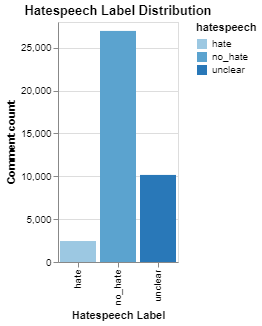

In [12]:
get_distribution(
    column_name="hatespeech",
    x_title="Hatespeech Label",
    y_title="Comment count",
    plot_title="Hatespeech Label Distribution",
    column=False
)

__The data is skewed. We have much more `no_hate` comments compared to `hate`. The number of `unclear` comments is also much less.__

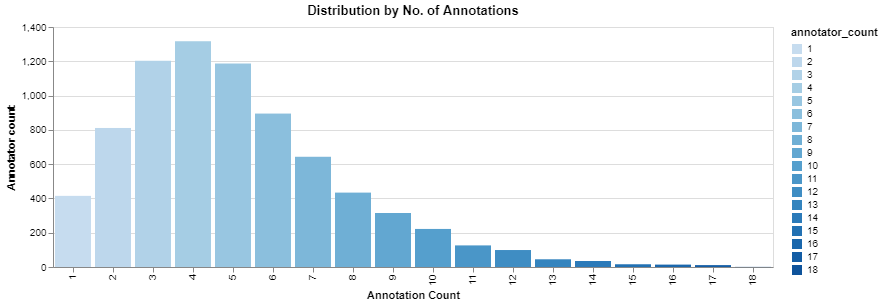

In [13]:
annotator_count = pd.DataFrame(
    hate_speech_dataset["annotator_id"].value_counts().values,
    columns=["annotator_count"]
)

get_distribution(
    column_name="annotator_count",
    x_title="Annotation Count",
    y_title="Annotator count",
    plot_title="Distribution by No. of Annotations",
    dataset=annotator_count,
    color_column="annotator_count",
    column=False
)

__Seems like a right-skewed Normal distribution as expected__

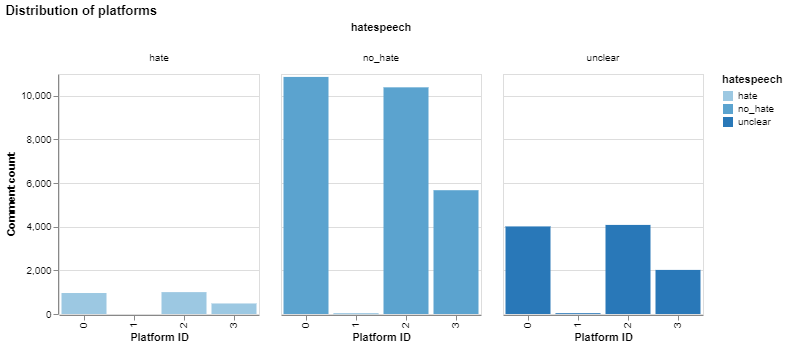

In [14]:
get_distribution(
    column_name="platform",
    x_title="Platform ID",
    y_title="Comment count",
    plot_title="Distribution of platforms"
)

__There are just a few entries from Platform 1. Platform 3 has less number of comments compared to the other two. The remaining two are similarly distibuted.__

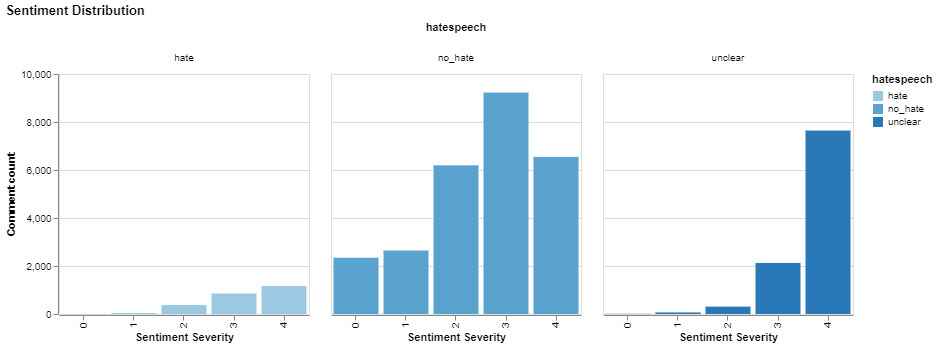

In [15]:
get_distribution(
    column_name="sentiment",
    x_title="Sentiment Severity",
    y_title="Comment count",
    plot_title="Sentiment Distribution"
)

__The sentiment severity is left-skewed , meaning the dataset contains more positive comments. This can be confirmed from the labels column.__

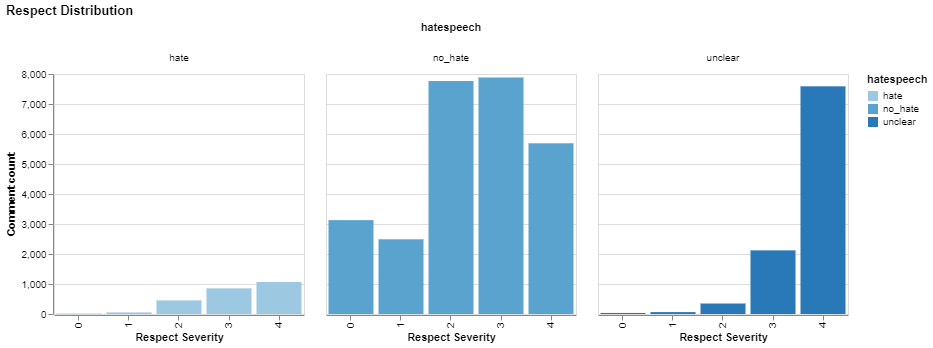

In [16]:
get_distribution(
    column_name="respect",
    x_title="Respect Severity",
    y_title="Comment count",
    plot_title="Respect Distribution"
)

__Same for the Respect column - Left skewed__

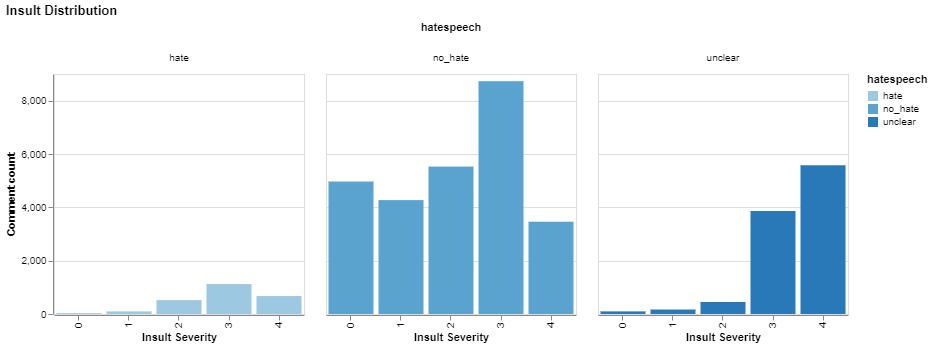

In [17]:
get_distribution(
    column_name="insult",
    x_title="Insult Severity",
    y_title="Comment count",
    plot_title="Insult Distribution"
)

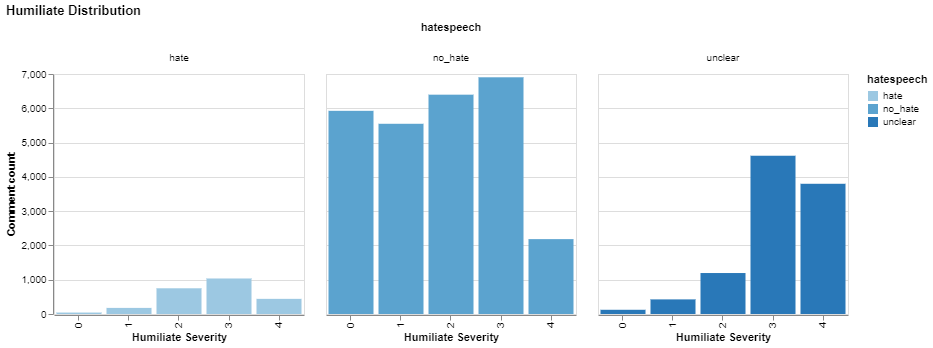

In [18]:
get_distribution(
    column_name="humiliate",
    x_title="Humiliate Severity",
    y_title="Comment count",
    plot_title="Humiliate Distribution"
)

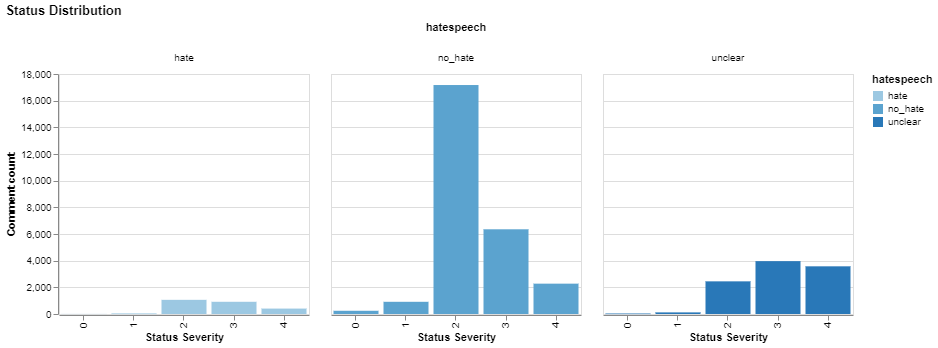

In [19]:
get_distribution(
    column_name="status",
    x_title="Status Severity",
    y_title="Comment count",
    plot_title="Status Distribution"
)

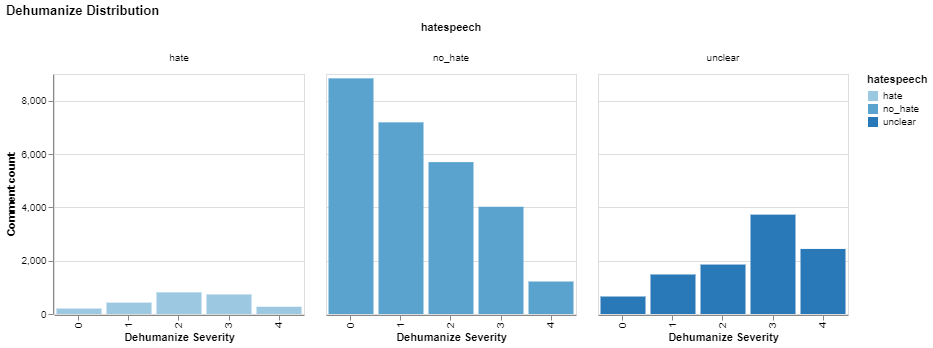

In [20]:
get_distribution(
    column_name="dehumanize",
    x_title="Dehumanize Severity",
    y_title="Comment count",
    plot_title="Dehumanize Distribution"
)

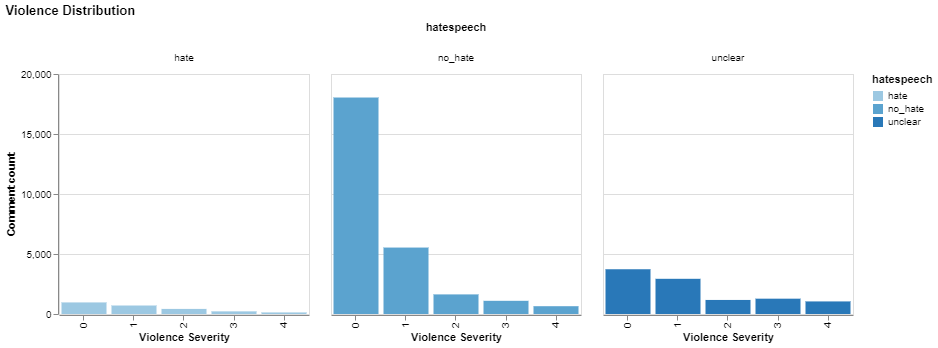

In [21]:
get_distribution(
    column_name="violence",
    x_title="Violence Severity",
    y_title="Comment count",
    plot_title="Violence Distribution"
)

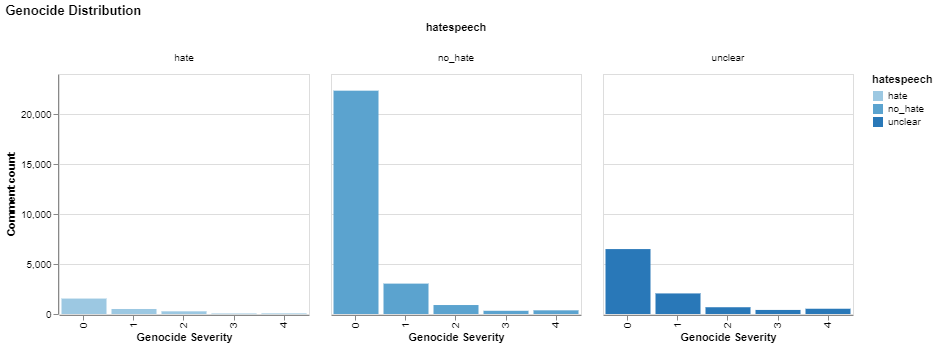

In [22]:
get_distribution(
    column_name="genocide",
    x_title="Genocide Severity",
    y_title="Comment count",
    plot_title="Genocide Distribution"
)

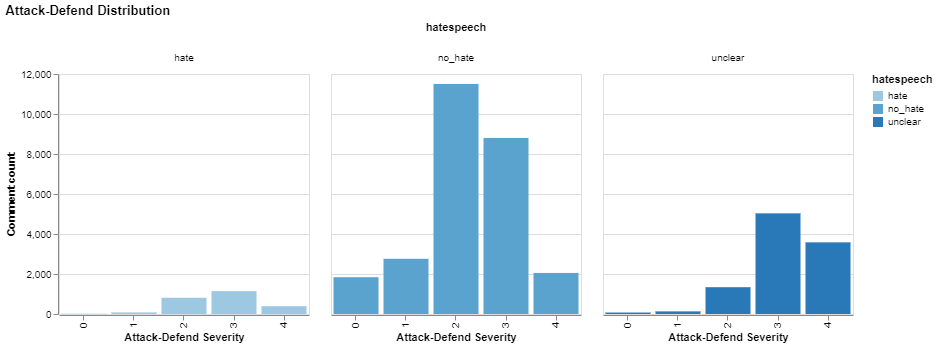

In [23]:
get_distribution(
    column_name="attack_defend",
    x_title="Attack-Defend Severity",
    y_title="Comment count",
    plot_title="Attack-Defend Distribution"
)

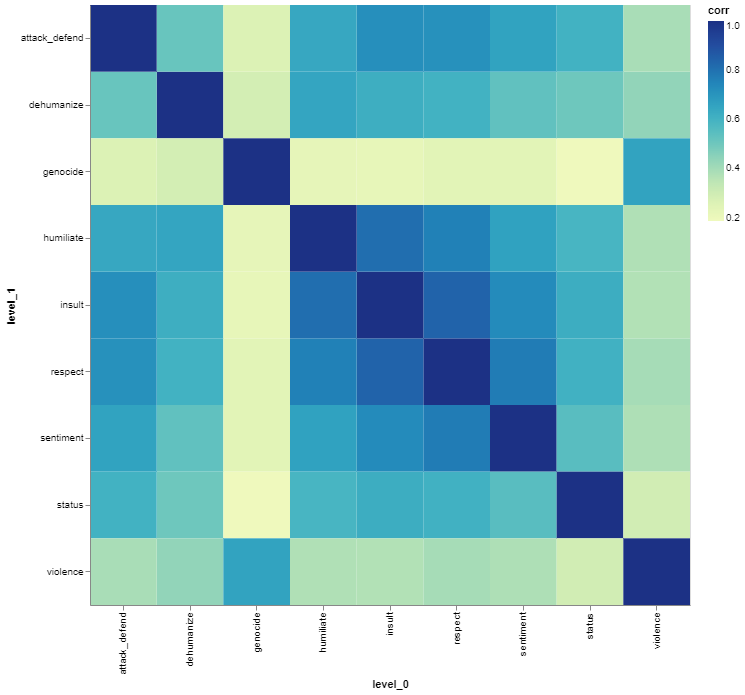

In [24]:
corr_df = (
    hate_speech_dataset[cat_column_list]
    .corr("spearman")
    .stack()
    .reset_index(name='corr'))

alt.Chart(corr_df).mark_rect().encode(
    x="level_0",
    y="level_1",
    tooltip="corr",
    color=alt.Color("corr")
).properties(
    width=600,
    height=600
)

From the above correlation plot, we comfirm that almost all features are positively correlated. This is expected because higher values for all these features suggests positive comments. However, genocide column is peculiarly not correlated with the other columns.

Genocide mentions: __Do you agree or disagree with the following statement: This comment calls for the deliberate killing of a large group of people from the group(s) you previously identified.__

High values here means more agreement, meaning more negativity. That is true for other columns too, so I expected this to be highly correlated with the other columns. 

We might want to dig a bit deeper into it!

__Let's move on to text column now...__

In [25]:
HATE_NO = "no_hate"
HATE_YES = "hate"
HATE_UNCLEAR = "unclear"

In [26]:
def print_comment_with_label(label, n_comments=5):
    hate_map = {
        HATE_NO: "Non-hatespeech",
        HATE_YES: "Hatespeech",
        HATE_UNCLEAR: "Not clear"
    }
    for comment in hate_speech_dataset[hate_speech_dataset["hatespeech"] == label]["text"][:n_comments]:
        print(f"{hate_map[label]}: {comment}")
        print("-" * 100)

In [27]:
print_comment_with_label(HATE_NO)

Non-hatespeech: White people are trash.
----------------------------------------------------------------------------------------------------
Non-hatespeech: Fabrice Fabrice is ostensibly black or black/latino (URL so that's part of it, beyond the gay stereotypes.
----------------------------------------------------------------------------------------------------
Non-hatespeech: First off you look cool as fuck! Anyway if we were in the bedroom I think I'd cream your ass then make you suck my cock clean like a whore ;)
----------------------------------------------------------------------------------------------------
Non-hatespeech: \*points to posters asking for palestinian rights and freedom\* theyre antisemetic and want to kill all the jews and dont acknowledge our right to exist ​ cant wait for this prick to die and go straight to hell. ill dig him the hole to get there myself
----------------------------------------------------------------------------------------------------
Non-ha

In [28]:
print_comment_with_label(HATE_YES)

Hatespeech: Donald Trump. Yeet myself off a building onto a gay dudes cock. And by gay dude, I mean Mike Pence.
----------------------------------------------------------------------------------------------------
Hatespeech: Sex is for normies
----------------------------------------------------------------------------------------------------
Hatespeech: I really want his star power as well. Curently I'm at 440 trophies with power 5... His star power will make him do much better. :)
----------------------------------------------------------------------------------------------------
Hatespeech: OKAY, I'LL LEAVE YOU FUCK YOURSELF LIKE A FUCKING DOG BARKING, BECAUSE I DON'T GIVE A FUCK TO A FUCKING BITCH LIKE YOU! I HOPE YOUR DICK-FACE FALLS ON A PIECE OF CRAP, HAVE A CRAPPY DAY, JACKARSE
----------------------------------------------------------------------------------------------------
Hatespeech: Joe Rogan...listen, dawg. That one time I had this Jamaican ho' up like this when I snorte

In [29]:
print_comment_with_label(HATE_UNCLEAR)

Not clear: You've caught the big gay, it's known to be airborne via dildos.
----------------------------------------------------------------------------------------------------
Not clear: I'm not saying you said that, I'm just saying that if you find a slur offensive (in this case the word niga) you'd find every other slur offensive. For me it's the opposite, I find none of them offensive because unless the context is bad no one should give a shit. I can call my black friend "niga" in a friendly way or in an evil way. There's a difference
----------------------------------------------------------------------------------------------------
Not clear: They'll come back in your plan, also. Plus we pay to jail them for 2 years. With my plan, we jail them after they come back. And deport them again. It really doesn't matter either way until we're build the wall, and shoot the invaders as enemies when they cross the border.
---------------------------------------------------------------------

In [30]:
def get_label_text(label):
    return hate_speech_dataset[hate_speech_dataset["hatespeech"] == label][["text", "hatespeech"]].to_dict()

In [31]:
hate_no = get_label_text(HATE_NO)
hate_yes = get_label_text(HATE_YES)
hate_unclear = get_label_text(HATE_UNCLEAR)

In [32]:
tweet_tokenizer = TweetTokenizer()
stopwords_set = set(stopwords.words("english"))
emojis = set(emoji.UNICODE_EMOJI["en"].keys())

#### All Texts

In [33]:
N_WORDS = 10

In [34]:
def get_stats(data_dict):
    num_emojis = 0
    tot_texts = 0
    word_counter = Counter()
    for sentence in data_dict["text"].values():
        tot_texts += 1
        tokens = tweet_tokenizer.tokenize(sentence)
        if any([token in emojis for token in tokens]):
            num_emojis += 1
        word_counter.update([token.lower() for token in tokens if token.lower() not in stopwords_set and token.isalpha()])
    return num_emojis / tot_texts, word_counter

In [35]:
def get_word_emoji_stats(text_type, dataset=hate_speech_dataset, n_words=N_WORDS):
    emojis_proportion, word_counter = get_stats(dataset)
    print(f"Average number of emojis per text in {text_type} texts: {round(emojis_proportion, 4)}")
    print("-" * 100)
    print(f"Top {N_WORDS} words in {text_type} texts: ")
    word_count_df = pd.DataFrame(word_counter.most_common(n_words), columns=["Word", "Count"])
    return alt.Chart(word_count_df).mark_bar().encode(
        alt.X("Count"),
        alt.Y("Word", sort="-x")
    )

Average number of emojis per text in all texts: 0.0832
----------------------------------------------------------------------------------------------------
Top 10 words in all texts: 


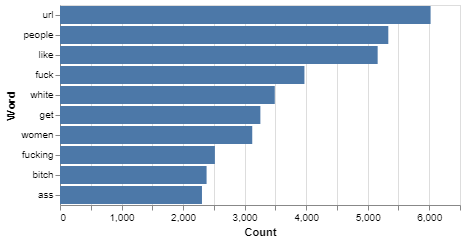

In [36]:
get_word_emoji_stats("all", dataset=hate_speech_dataset.to_dict())

#### Hate-speech Texts

Average number of emojis per text in hatespeech texts: 0.0931
----------------------------------------------------------------------------------------------------
Top 10 words in hatespeech texts: 


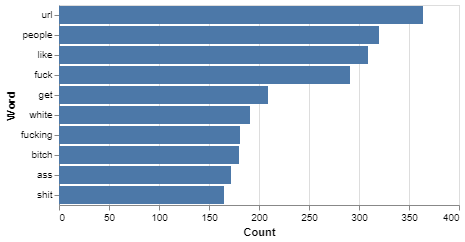

In [37]:
get_word_emoji_stats("hatespeech", dataset=hate_yes)

#### Non-hate-speech Texts

Average number of emojis per text in no hatespeech texts: 0.0803
----------------------------------------------------------------------------------------------------
Top 10 words in no hatespeech texts: 


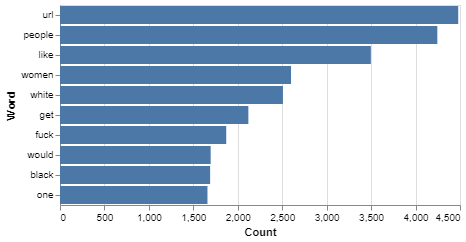

In [38]:
get_word_emoji_stats("no hatespeech", hate_no)

#### Unclear Texts

Average number of emojis per text in unclear texts: 0.0884
----------------------------------------------------------------------------------------------------
Top 10 words in unclear texts: 


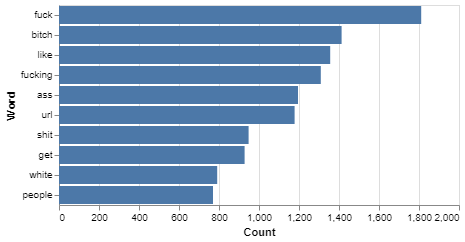

In [39]:
get_word_emoji_stats("unclear", hate_unclear)

__We notice how hate text contains more proportion of emojis compared to other categories. We see that the hate-speech texts contain many swear and offending words.__

### Interpretation with Word Clouds

In [40]:
puncs = re.sub("[!?',&:\.\"#$%()+-/;<=>@^_`{|}~\\\\\\[\\]]", "", string.punctuation)
ascii_art = r"(?:\w+[{punctuation}]*\w+)".format(punctuation=puncs)
regexp = r"{ascii_art}".format(ascii_art=ascii_art)

In [41]:
def clean_text(text):
    BAD_WORDS = {
        "nigga": "n***a",
        "fuck": "f**k",
        "bitch": "b***h",
        "dick": "d**k",
        "cock": "c**k",
        "ass": "a**",
        "pussy": "p***y",
        "sex": "s**",
        "nigger": "n****r",
        "faggot": "f****t",
        "slut": "s**t",
        "shit": "s**t",
        "retard": "r****d",
        "killed": "k****d",
        "suck": "s**k",
        "hoe": "h**",
        "ugly": "u**y",
        "nazi": "n**i",
        "cunt": "c**t",
        "cum": "c**"
    }
    text = text.lower()
    for word, replacement in BAD_WORDS.items():
        text = text.replace(word, replacement)
    return text

In [42]:
def generate_wordcloud(text_type="all", dataset=hate_speech_dataset.to_dict()):
    wordcloud = WordCloud(width=1200, height=600, stopwords=stopwords_set, regexp=regexp).generate(
        clean_text(" ".join([sentence for sentence in dataset["text"].values()]))
    )
    plt.figure(figsize=(10, 8))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

#### All Texts

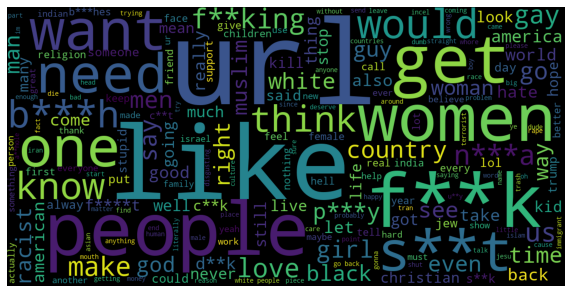

In [43]:
generate_wordcloud("all", hate_speech_dataset.to_dict())

#### Hatespeech Texts

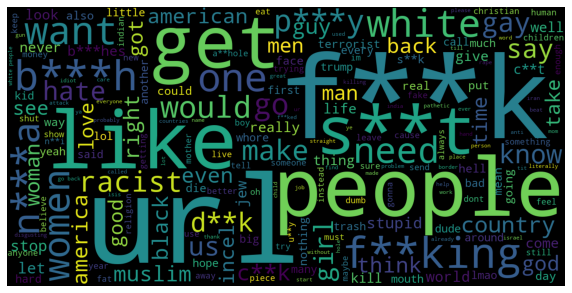

In [44]:
generate_wordcloud("hatespeech", hate_yes)

#### Non-Hatespeech Texts

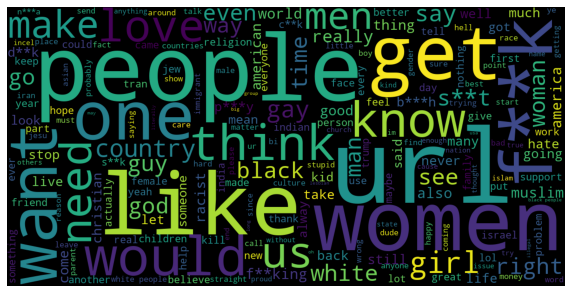

In [45]:
generate_wordcloud("no hatespeech", hate_no)

#### Unclear Texts

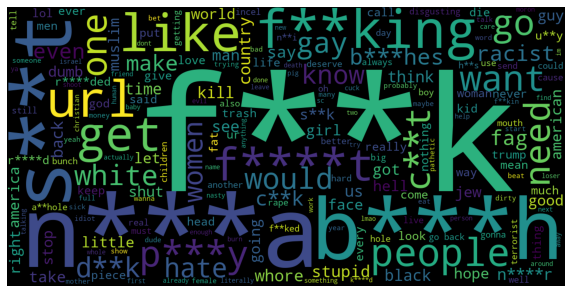

In [46]:
generate_wordcloud("unclear", hate_unclear)

__It's possible to see that the language in this dataset is vulgar and is full of swear words for hate text. Unclear texts contain a lot of swear words too, and that is what makes them difficult to classify from non-hate text. Non-hate text contains much less swear words in comparison__

## Result

Now that we have done the EDA, let's summarize what all we inferred:

- The data is skewed. We have much more `no_hate` comments compared to `hate`. The number of `unclear` comments is also much less.

    ```
    no_hate    26959
    unclear    10158
    hate        2448
    ```


- The distribution of number of comments annotated by each annotator is a rightly-skewed Normal distribution.
- There are just a few entries from Platform 1. Platform 3 has less number of comments compared to the other two. Platform 0 and 1 are similarly distibuted.
- The sentiment severity is left-skewed , meaning the dataset contains more positive comments. This can be confirmed from the labels column.
- There is nothing peculiar about the categorical columns. All seem to be in agreement with the label distribution.
- From the correlation plot, we see that almost all features are positively correlated. However, genocide column is peculiarly not correlated with the other columns. I expected this to be highly correlated with the other columns. We might want to dig a bit deeper into it!
- We notice how hate text contains more proportion of emojis compared to other categories. We see that the hate-speech texts contain many swear and offending words.
- It's clear from the word-clouds too that the language in this dataset is vulgar and is full of swear words for hate text. Unclear texts contain a lot of swear words too, and that is what makes them difficult to classify from non-hate text. Non-hate text contains much less swear words in comparison.

There are a lot of other things we can do with the text in this dataset such as playing with the __POS tags, Named entities, Polarity classification, text readability__, etc. But I will leave it at this for now because of shortage of time.

Overall, this dataset can be used for multiple downstream tasks such as __sentiment analysis, hate-speech detection, propaganda identification__, etc.